# Bayesian Optimisation Assignment

In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)

In [3]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.verbose = False
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.transpose(k_star) @ self.K_inv @ self.y_train
        f_std = self.cov_func(x_star, x_star) - np.transpose(k_star) @ self.K_inv @ k_star
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]
    
    def set_training_data(self,x,y):
        self.x_train = x
        self.y_train = y
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            K = self.hyper_params[0]**2 * np.exp(-0.5 * d/self.hyper_params[1]**2)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*(np.transpose(self.y_train) @ self.K_inv @ self.y_train)
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3
    
    def fit(self):
        print("GP Optimising Hyper-parameters")
        from scipy.optimize import minimize

        def eval_params(params, gp):
            params = np.exp(params)
            gp.set_hyper_params(params[:-1],params[len(params)-1])
            nlml = -gp.log_marginal_likelihood()
            if gp.verbose:
                print(str(params)+str(nlml))
            return nlml

        x0 = np.array([np.log(2), np.log(0.8), np.log(0.3)])
        res = minimize(eval_params, x0, method='nelder-mead', args=(self),
                       options={'xatol': 1e-10, 'disp': False})
        if res.success:
            print("Optimisation results: ")
            optimal_params = np.exp(res.x)
            print(optimal_params)
            print("LML")
            print(self.log_marginal_likelihood())
            self.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])
        else:
            print("Error when fitting GP.")

### Objective Function
The following is the objective function for the problem:

\begin{equation}
f(x) = 6x^2\sin{(5\pi x)} + \epsilon \,\,,
\end{equation}
where $\epsilon \sim \mathcal{N}(0,0.2^2)$ and $x \in [0, 1]$

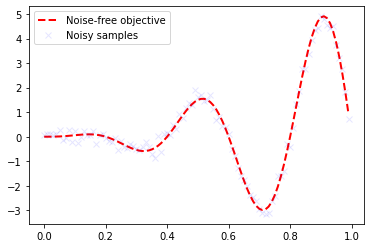

In [4]:
# Definition of the objective function
def f(X, noise=0):
    return 6*X**2*np.sin(5*np.pi*X)+ noise * np.random.randn(*X.shape)

# Dense grid of points within bounds for plotting
bounds = np.array([[0, 1.0]])
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

noise = 0.2 #Measurement noise for f

# Plot optimization objective with noise level 
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X,noise=noise), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.legend();
plt.show()

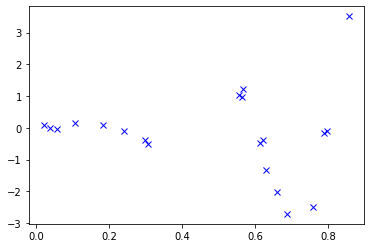

In [5]:
n_samples = 20
x_train = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=n_samples)[:,np.newaxis]
y_train = f(x_train,noise)

plt.plot(x_train, y_train, 'bx', label='Noisy samples')
plt.show()

GP Optimising Hyper-parameters
Error when fitting GP.


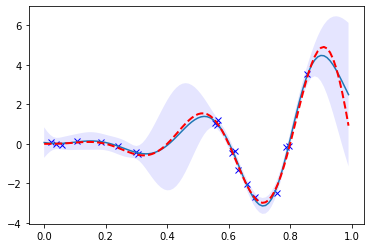

In [6]:
signal_variance = 1
lengthscale = 1
sigma_n = 1

x_star = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

gp = GP("Squared Exponential", x_train, y_train, [signal_variance, lengthscale], sigma_n) ##TODO define a train GP model

gp.fit()

[f_mean,f_std] = gp.predict(x_star) ##TODO predict GP values

plt.fill_between(x_star.ravel(), (f_mean-1.96*f_std).ravel(), (f_mean+1.96*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_train, y_train, 'bx', label='Noise-free objective')
plt.plot(x_star, f_mean)
plt.plot(X, f(X,noise=0), 'r--', lw=2, label='Noise-free objective')
plt.show()

## Bayesian Optimisation

The following cells execute Bayesian optimisation, but before the core algorithm, we need to define utility functions used by the main algorithm for evaluating the acquisition functions, maximising the acquisition function and plotting the results.

### Acquisition Functions

#### Expected Improvement (EI)

\begin{equation}
    EI(\mathbf{x}) = \sigma(\mathbf{x})[Z \Phi(Z)+\phi(Z)]\,,
\end{equation}
where
\begin{equation}
    Z = \frac{\mu(\mathbf{x})-f(\mathbf{x}^+)-\xi}{\sigma(\mathbf{x})}
\end{equation}
and $\phi$, $\Phi$ are the Normal PDF and CDF respectively.

<b>Note:</b> We do not usually have access to the true $f(\mathbf x^+)$. So we need to estimate $f(\mathbf x^+)$ based on the information that's been collected so far, via e.g.:
\begin{equation}
    f(\mathbf x^+) \approx y^+ = \max(y_1, \dots, y_t),
\end{equation}
which is the maximum observation value up to the current iteration, $t$. In this case, we are implicitly assuming that the noise in the observations is not too high. A better alternative for $f(\mathbf x^+)$, in the case of noisy observations, is:
\begin{equation}
    f(\mathbf x^+) \approx \mu^+ = \max(\mu(\mathbf x_1), \dots, \mu(\mathbf x_t)),
\end{equation}
which uses the GP predictive mean to "filter out" the noise in the observations. In addition, the parameter $\xi$ allows EI to deal with noise by setting it according to the noise level, i.e., the higher the amount of noise, the higher $\xi$ should be.

#### Upper Confidence Bound (UCB)
\begin{equation}
    UCB(\mathbf x) = \mu(\mathbf x) + \kappa \sigma(\mathbf x)
\end{equation}
where $\kappa > 0$ controls the <i>exploration-exploitation trade-off</i>.

<b>Note:</b> In the limit when $\kappa \to 0$, UCB becomes pure exploitation, i.e., we're simply following locations with high expected value, completely disregarding the uncertainty in the model. This behaviour often leads BO to get stuck into local optima. In contrast, when $\kappa \to \infty$, UCB becomes pure exploration, leading BO to simply follow the model uncertainty, regardless of how promising the objective function value is expected to be at the queried locations. Therefore, ideally, $\kappa$ should be set accordingly to balance these two extreme behaviours (exploitation and exploration). The same kind of balance can be adjusted on the EI when setting $\xi$ to a non-zero value. However, when it is actually needed, tuning EI is usually more difficult in practice than tuning UCB.

In [19]:
def EI(X, X_sample, Y_sample, gpr, xi=0.02):
    ## TODO
    mean, std = gpr.predict(X)
    y_max = Y_sample.max()
    z = (mean - y_max -xi)/std
    ei = std * (z * norm.cdf(z) + norm.pdf(z))
    return ei

In [8]:
def ucb(X, X_sample, Y_sample, gp, kappa=1):
    ## TODO
    mean, std = gp.predict(X)
    ucb_val = mean + kappa * std
    return ucb_val

#### Probability of Improvement (PI)

$$PI(\mathbf x) = \Phi\bigg(\frac{\mu(\mathbf x) - f(\mathbf x^+) - \xi}{\sigma(\mathbf x)}\bigg)$$


In [9]:
def PI(X, X_sample, Y_sample, gp, xi=0.02):
    mean, std = gp.predict(X)
    y_max = Y_sample.max()
    z = (mean - y_max -xi)/std
    pi_val = norm.cdf(z)
    return pi_val

#### Regret

The regret for function $f$ at iteration $i$ is defined as:
$$\mathcal{R}(f, i) = f(x^*) - f(x^{BO_{i}})$$

where, $f(x^{BO_{i}})$ is BO-estimated maximum value of $f$ at iteration $i$.

In [48]:
def regret(x_next, Y_sample):
    return np.sum(Y_sample.max() - f(x_next))

In [49]:
def arg_max_aq_func(ac_func, X_sample, Y_sample, gp, bounds, n_restarts=25):
    # Domain to evaluate the acquisition function
    x_sample_aq = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
    # Values of the acquisition function over the domain
    aq_values = ac_func(x_sample_aq, X_sample, Y_sample, gp)
    # Argmax of the acquisition funcion values
    return x_sample_aq[np.argmax(aq_values)]

In [50]:
def plot_acquisition_function(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r.', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    

def plot_gp_regression(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X)
    plt.plot(X, Y, 'r--', lw=1, label='Noise-free objective')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    plt.plot(X_domain, mu, 'b', lw=1, label='Surrogate function')
    plt.fill_between(X_domain.ravel(), 
                     mu.ravel() + 1.96 * std.ravel(), 
                     mu.ravel() - 1.96 * std.ravel(), 
                     alpha=0.1) 
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()


In [54]:
def optimize(f, bounds, X_init, n_iter, aq_func):

    Y_init = f(X_init)

    # Initialize samples
    X_sample = X_init
    Y_sample = Y_init

    regrets = []

    plt.figure(figsize=(12, n_iter * 3))
    plt.subplots_adjust(hspace=0.4)

    for i in range(n_iter):
        ## TODO
        # 1. Update GP
        gp.set_training_data(X_sample, Y_sample)

        # 2. Calculate X_next
        X_next = arg_max_aq_func(aq_func, X_sample, Y_sample, gp, bounds) ## todo
        
        # 3. Acquire next observation
        Y_next = f(X_next) ## todo

        # 4. Regret for the current iteration
        regrets.append(regret(X_next, Y_sample))
        
        # Plotting
        plt.subplot(n_iter, 2, 2 * i + 1)
        plot_gp_regression(gp, X_domain, y_perfect, X_sample, Y_sample, X_next, show_legend=i==0)
        plt.title(f'Iteration {i+1}')

        plt.subplot(n_iter, 2, 2 * i + 2)
        plot_acquisition_function(X_domain, aq_func(X_domain, X_sample, Y_sample, gp), X_next, show_legend=i==0)
        
        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))


    cummulative_regret = np.cumsum(regrets)
        
    plt.show()

    return regrets, cummulative_regret

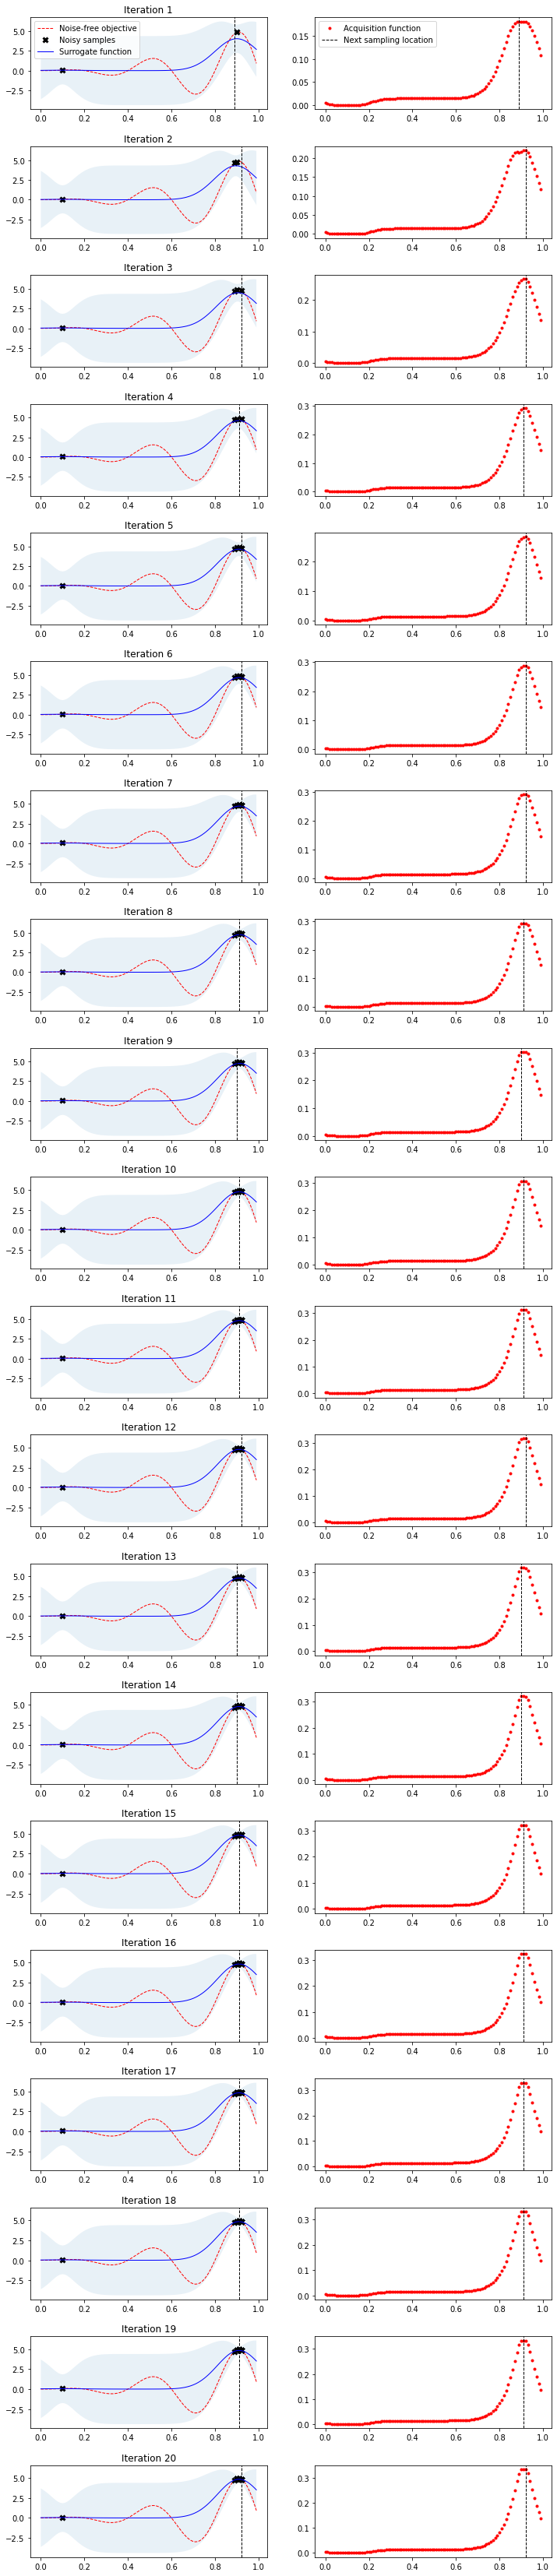

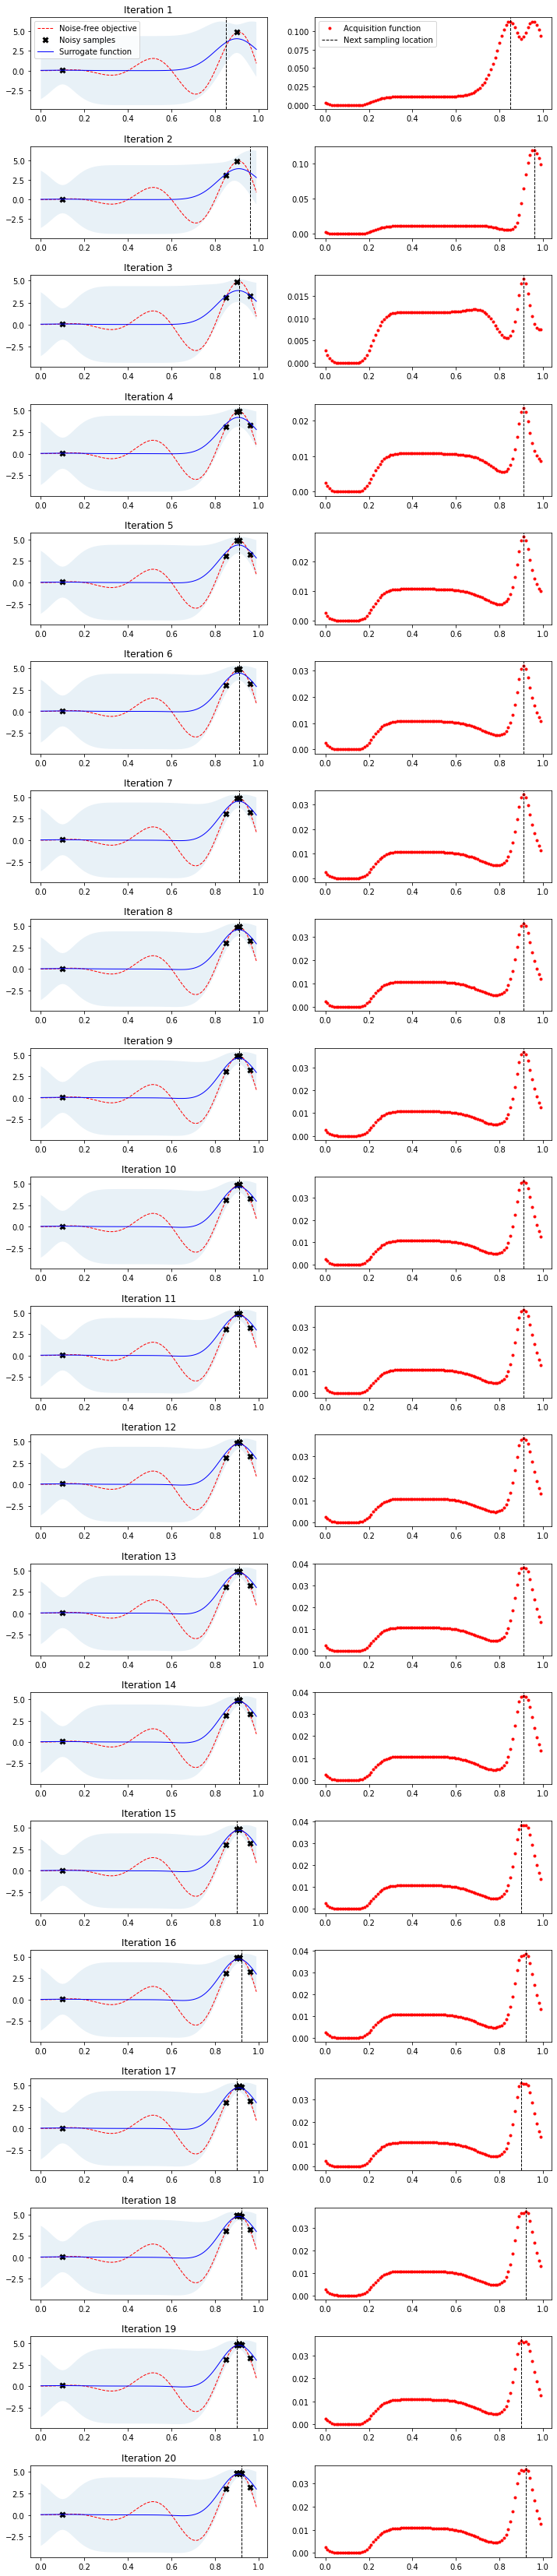

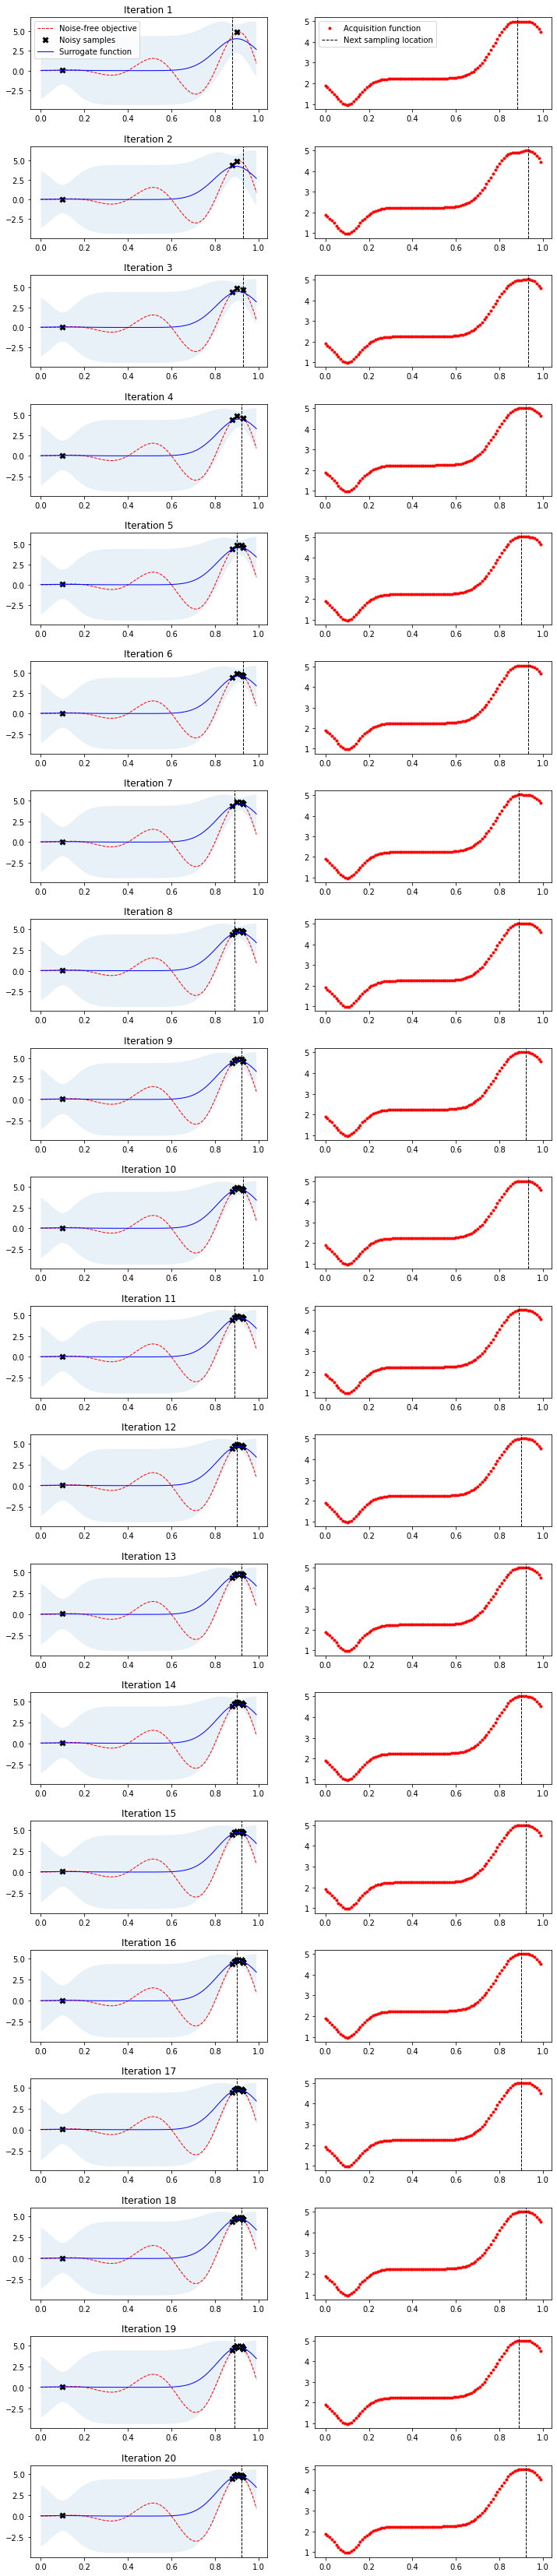

In [55]:
X_init = np.array([[0.1], [0.9]])
n_iter = 20

#perfect values of function (just for plotting)
X_domain = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
y_perfect = f(X_domain, noise=0)

cumulative_regret = {}
regrets = {}

for aq_func in [PI, EI, ucb]:
    regrets[aq_func], cumulative_regret[aq_func] = optimize(f, bounds, X_init, n_iter=n_iter, aq_func=aq_func)

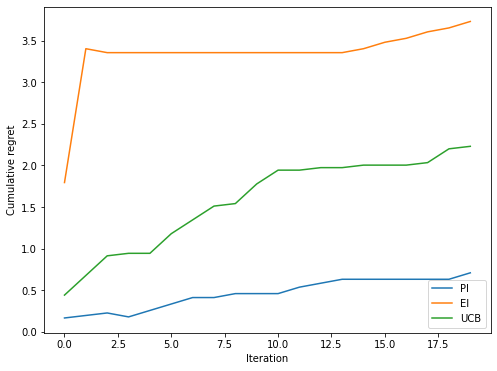

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(cumulative_regret[PI], label='PI')
ax.plot(cumulative_regret[EI], label='EI')
ax.plot(cumulative_regret[ucb], label='UCB')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cumulative regret')
ax.legend()

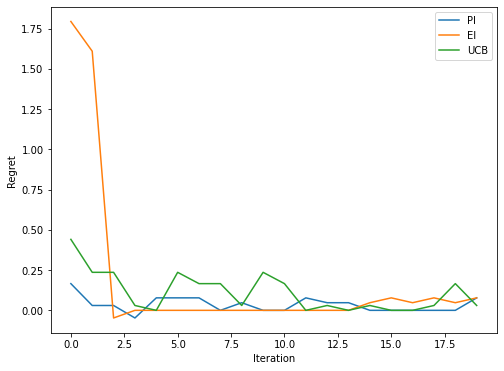

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(regrets[PI], label='PI')
ax.plot(regrets[EI], label='EI')
ax.plot(regrets[ucb], label='UCB')
ax.set_xlabel('Iteration')
ax.set_ylabel('Regret')
ax.legend()

In [68]:
from IPython.display import display, Markdown, Latex
display(Markdown(
f"""## Performance Results:

#### Final Regret for each aquisition method:


|  Method | Regret (R) | Cumulative Regret (CR) |
|---|---|---|
| Expected Improvement (EI) | {regrets[EI][-1]:.4f} | {cumulative_regret[EI][-1]:.4f} |
| Probability of Improvement (PI) | {regrets[PI][-1]:.4f} | {cumulative_regret[PI][-1]:.4f} |
|  Upper Confidence Bound (UCB)| {regrets[ucb][-1]:.4f} | {cumulative_regret[ucb][-1]:.4f} |

"""))

## Performance Results:

#### Final Regret for each aquisition method:


|  Method | Regret (R) | Cumulative Regret (CR) |
|---|---|---|
| Expected Improvement (EI) | 0.0776 | 3.7321 |
| Probability of Improvement (PI) | 0.0776 | 0.7090 |
|  Upper Confidence Bound (UCB)| 0.0302 | 2.2304 |

